# Colorization

This notebook is used to test conditioned diffusion for image colorization.

## Imports

In [1]:
from accelerate import data_loader
from torchvision import datasets
import tqdm
import os
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from unet import Unet
from diffusion_conditioned import DiffusionConditioned
from channel_engineering import rgb_to_lab, normalize_lab, unnormalize_lab, lab_to_rgb
from model_utils import ConcatModel, ConcatModelNoT

In [2]:
# Initialize diffusion process and model
timesteps = 1000
#t_reconst=200
num_epochs = 5
device = torch.device("cuda")

## Dataset import

In [3]:

# Set up data loader
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to PyTorch tensor
    transforms.CenterCrop(128),  # Crop to the central 128x128 region
    #transforms.Resize((128, 128)),  # Resize to 256x256
])
#train_dataset = datasets.CIFAR10(root="data", train=True, transform=transform, download=True)
train_dataset = datasets.CelebA(root="data", transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)




Files already downloaded and verified


In [4]:
class Loader():
    def __init__(self, data_loader):
        self.data_loader = data_loader
        self.pbar = tqdm.tqdm(data_loader)
    def __iter__(self):
        for elt in self.pbar:
            images = elt[0]
            lab_images = normalize_lab(rgb_to_lab(images))
            yield lab_images[:,0:1], lab_images[:,1:]
        self.pbar = tqdm.tqdm(self.data_loader)
    def log(self, name, val):
        self.pbar.set_description(f"{name}: {val:.4f}")
def gene():
    for elt in tqdm.tqdm(train_loader):
        images = elt[0]
        lab_images = normalize_lab(rgb_to_lab(images))
        yield lab_images[:,0:1], lab_images[:,1:]

model = ConcatModel(Unet(channels=128, out_channels=2)).to(device)

nb_params = sum([elt.numel() for elt in model.parameters()])
print(f"nb params : {nb_params}")
diffusion = DiffusionConditioned(model, timesteps=timesteps, device=device, beta_start=1e-4, beta_end=2e-2)

# Load img
img_l, img_ab = next(gene())  
img_l,img_ab = img_l[0].unsqueeze(0), img_ab[0].unsqueeze(0)

nb params : 18618880


  0%|          | 0/5087 [00:00<?, ?it/s]


In [5]:


# Train model
#state_dict = torch.load('model_best.pth')
#diffusion.model.load_state_dict(state_dict)
#diffusion.train(Loader(train_loader), num_epochs=num_epochs, to_save=True, lr=2*1e-4)


In [6]:
state_dict = torch.load('model_4.pth')
diffusion.model.load_state_dict(state_dict)
#torch.save(diffusion.model.state_dict(), 'model_best_128.pth')

/tmp/ipykernel_120104/4113439136.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('model_4.pth')


<All keys matched successfully>

In [7]:
nb_img = 10
T=300
imgs_l, imgs_ab = next(gene())  
base_img = torch.concatenate([imgs_l, imgs_ab], dim=1).to(device)[:nb_img]
imgs_l, imgs_ab = imgs_l.to(device)[:nb_img], imgs_ab.to(device)[:nb_img]
shape = imgs_ab.shape
img_gen = diffusion.sampling(imgs_l,shape)
#noised = diffusion.forward_diffusion(imgs_ab, T)[0]
#img_gen = diffusion.sampling(imgs_l,shape, T=T, xT=noised)





  0%|          | 0/5087 [00:00<?, ?it/s]


In [8]:
img_lab = torch.concat([imgs_l, img_gen], dim=1)
#img_noised_lab = torch.concat([imgs_l, noised], dim=1)
img_rgb = lab_to_rgb(unnormalize_lab(img_lab), device = img_lab.device)
base_img_rgb = lab_to_rgb(unnormalize_lab(base_img), device = img_lab.device)
#img_noised_rgb = lab_to_rgb(img_noised_lab, device = img_noised_lab.device)

from colorization_module import ColorizationModule
for elt in tqdm.tqdm(train_loader):
    break
coloring = ColorizationModule(diffusion, transform=None)

img_rgb,_ = coloring(elt[0][:5].to(device))

  0%|          | 0/5087 [00:00<?, ?it/s]


/tmp/ipykernel_120104/3010213080.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


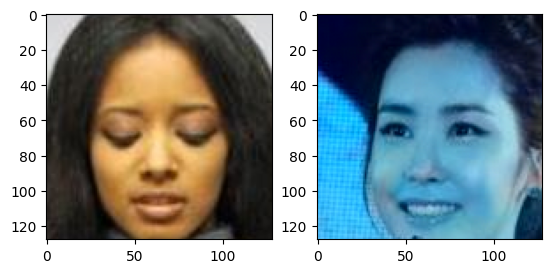

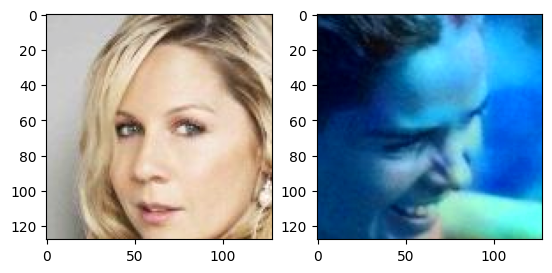

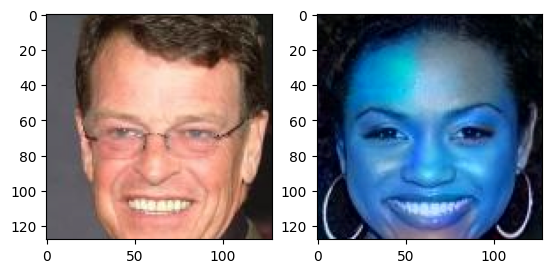

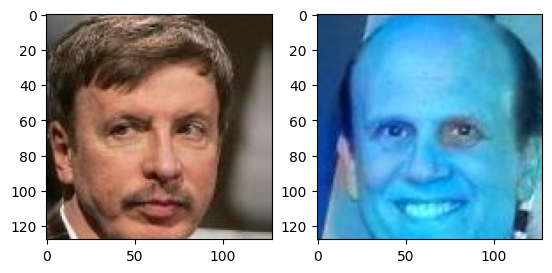

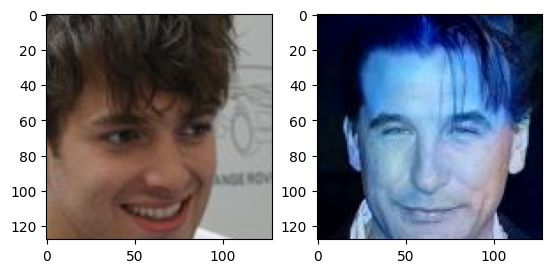

In [9]:
for img_base,img_generated in zip(base_img_rgb,img_rgb):
    fig,axes = plt.subplots(1,2)
    axes[0].imshow(np.clip(img_base.permute(1,2,0).detach().cpu().numpy(), 0, 1))
    axes[1].imshow(np.clip(img_generated.permute(1,2,0).detach().cpu().numpy(), 0, 1))
    fig.show()

In [10]:
noised = diffusion.forward_diffusion(imgs_ab, T)[0]
img_noised_lab = torch.concat([imgs_l, noised], dim=1)
img_noised_rgb = lab_to_rgb(img_noised_lab, device = img_noised_lab.device)



/tmp/ipykernel_120104/365544886.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


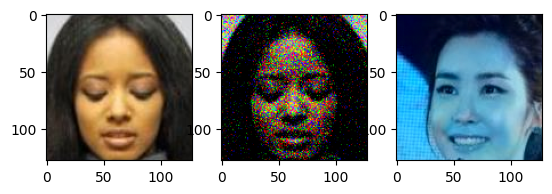

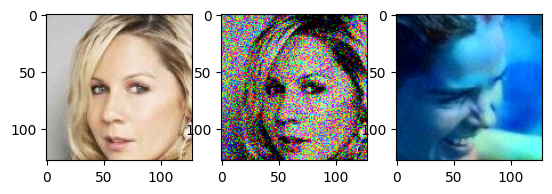

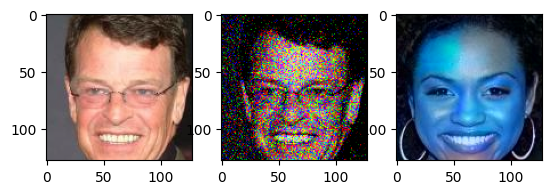

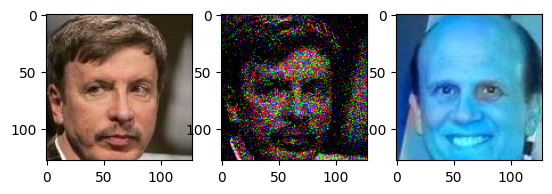

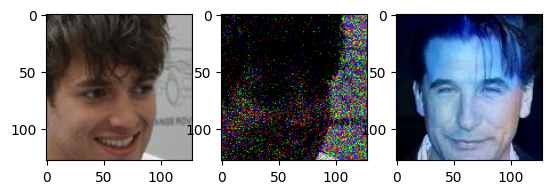

In [11]:
for img_base,img_generated, img_noised in zip(base_img_rgb,img_rgb, img_noised_rgb):
    fig,axes = plt.subplots(1,3)
    axes[0].imshow(np.clip(img_base.permute(1,2,0).detach().cpu().numpy(), 0, 1))
    axes[1].imshow(np.clip(img_noised.permute(1,2,0).detach().cpu().numpy(), 0, 1))
    axes[2].imshow(np.clip(img_generated.permute(1,2,0).detach().cpu().numpy(), 0, 1))
    fig.show()